# Capstone Deliverable 1: Data Investigation

## Business Scenario

In order to validate the launch of a tiered subscription service for the the current streaming platform, management has asked to create a product that mines historical customer data to seamlessly predict monthly revenue for a specific country. In order to accelerate development time and demonstrate a product MVP, this product will focus on data mined from the ten countries that have historically provided the highest revenue.

## Ideal Data

To develop this product, an ideal dataset would include timeseries information on customers, number of views, products and revenue, by country. This information would ideally include number of unique users in a country at any given time, number of unique purchases as well as total revenue. This information could give us the opportunity to identify which country is growing in userbase, which userbase is willing to pay for premium content on average.

## Set up the Jupyter Notebook including required modules and directories

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sg.cslib import fetch_data

In [3]:
data_dir = os.path.join(os.path.dirname(os.path.abspath('Capstone_Deliverable_1_EDA.ipynb')),'cs-train')

In [4]:
countries_df = fetch_data(data_dir)

## High level EDA

It is always a good idea to get a 10,000 foot view of the data. What we will investigate is the overall shape and structure of the data now that we have ingested it from JSON. This familiarization with the data helps us get our bearings and understand where additional cleaning may be needed.

In [5]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815011 entries, 0 to 815010
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       815011 non-null  object        
 1   customer_id   625249 non-null  float64       
 2   day           815011 non-null  int64         
 3   invoice       815011 non-null  object        
 4   month         815011 non-null  int64         
 5   price         815011 non-null  float64       
 6   stream_id     815011 non-null  object        
 7   times_viewed  815011 non-null  int64         
 8   year          815011 non-null  int64         
 9   invoice_date  815011 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 62.2+ MB


Looking at the dataframe shape we see that it includes 815,011 records, each with 10 fields (attributes). It is also readily seen that the customer_id field is the only one that includes non-null values. One other insight is that the structure of the data (i.e. day, month and year each being in their own field) will make time series analysis challenging. We will need to combine those later to allow for improved analysis.

In [6]:
countries_df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [7]:
countries_df[['price','times_viewed','year']].describe()

,price,times_viewed,year
count,815011.000000,815011.000000,815011.000000
mean,4.802631,5.231106,2018.247654
std,135.058707,5.109982,0.545261
min,-53594.360000,0.000000,2017.000000
25%,1.250000,1.000000,2018.000000
50%,2.100000,3.000000,2018.000000
75%,4.210000,8.000000,2019.000000
max,38970.000000,24.000000,2019.000000


We will plot the distributions of these values below, but its good to get a statistical summary. Something to notice is that within the price column there are negative values. This may be an error, or it could represent a promotion. Something to keep an eye on and consider. Regardless, looking at the min and max, these values that are significantly far from the upper and lower quartiles may impact the overall model as outlier values.

In the interest of development time, we will be limiting our focus to the ten countries with the most revenue. Let's cut out dataset down so that out visualization can be more focused.

In [8]:
grouped_country_df = countries_df[['country','price','times_viewed']].groupby(by = "country").aggregate( 'sum').sort_values(by = 'price', ascending = False)

In [9]:
grouped_country_df.head(10)

,price,times_viewed
country,,
United Kingdom,3.521514e+06,3725703
EIRE,1.070692e+05,111636
Germany,4.927182e+04,112618
France,4.056514e+04,83124
Norway,3.849475e+04,7881
Spain,1.604099e+04,19573
Hong Kong,1.445257e+04,2635
Portugal,1.352867e+04,14195
Singapore,1.317592e+04,3042


In [10]:
top_ten_countries = list(grouped_country_df.head(10).index)

In [11]:
top_ten_df = countries_df[countries_df['country'].isin(top_ten_countries)]

In [12]:
top_ten_df['country'].value_counts()

United Kingdom    751228
EIRE               13577
Germany            13336
France              9899
Netherlands         4024
Spain               2606
Portugal            1815
Norway               796
Singapore            310
Hong Kong            276
Name: country, dtype: int64

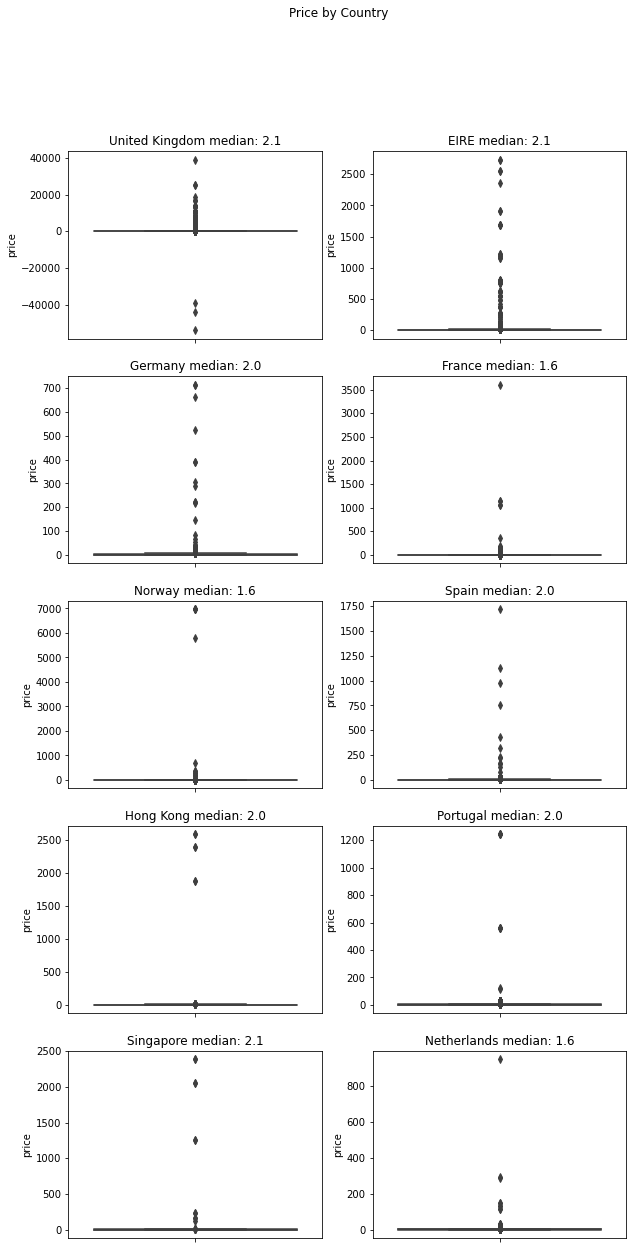

In [13]:
fig, axes = plt.subplots(5,2, figsize = (10,20));
fig.suptitle('Price by Country');
#x = top_ten_df[top_ten_df['country'] == top_ten_countries[i]]['price'],
for i in range(len(axes.flatten())):
    sns.boxplot(data = top_ten_df,y = top_ten_df[top_ten_df['country'] == top_ten_countries[i]]['price'], ax = axes.flatten()[i])
    #print(np.mean(top_ten_countries[i]['price'].values))
    axes.flatten()[i].set_title(top_ten_countries[i] + f" median: {np.median(top_ten_df[top_ten_df['country'] == top_ten_countries[i]]['price']):0.1f}")

Using these plots in conjunction with the statistical summary provided above ,we see that each country has several datapoints well beyond their uppler and lower quartiles, wit the U.K. the only country with negative datapoints. Its also interesting to see how the median values as well as the ranges compare.

We can also explore the revenue distribution by country. Note that because the U.K. has by far the greatest revenue, it is helpful to provide visualizations with the next top 9 countries alone for greater comparison.

In [14]:
grouped_top_ten_df = top_ten_df[['country','price','times_viewed']].groupby(by = 'country').agg('sum').sort_values(by = 'price', ascending = False)

In [15]:
exclude = grouped_top_ten_df.index.isin(['United Kingdom'])
grouped_top_nine = grouped_top_ten_df[~exclude]

Text(0.5, 1.0, 'Top Nine Countries (U.K. Eliminated for scale)')

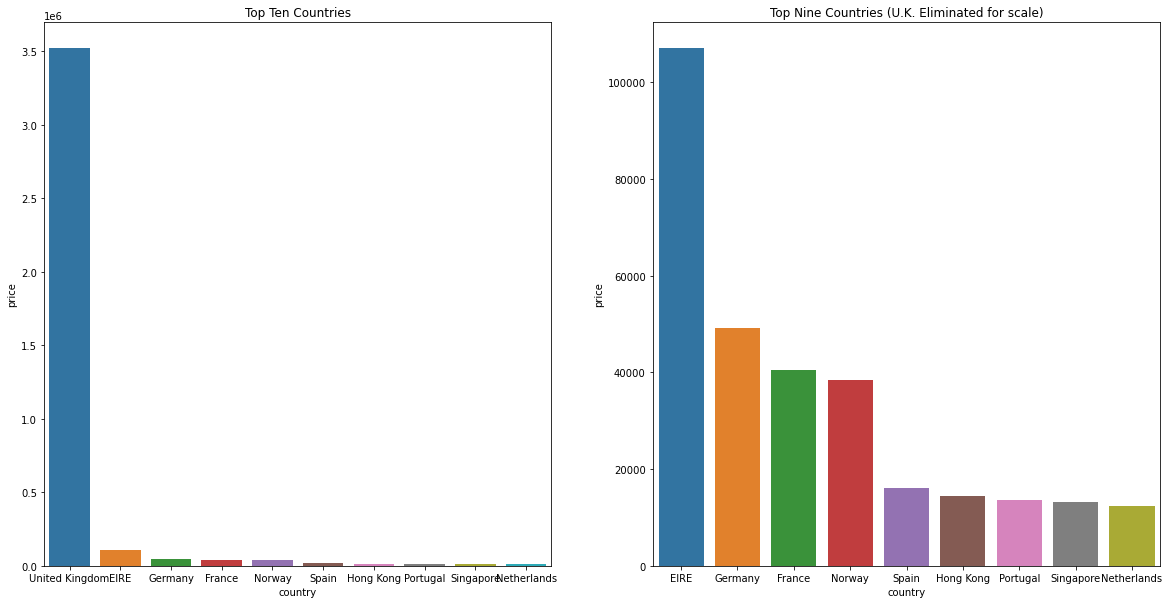

In [16]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
sns.barplot(ax = ax[0],data = grouped_top_ten_df, x = grouped_top_ten_df.index, y ='price')
sns.barplot(ax = ax[1],data = grouped_top_nine, x = grouped_top_nine.index, y ='price')
ax[0].set_title('Top Ten Countries')
ax[1].set_title('Top Nine Countries (U.K. Eliminated for scale)')

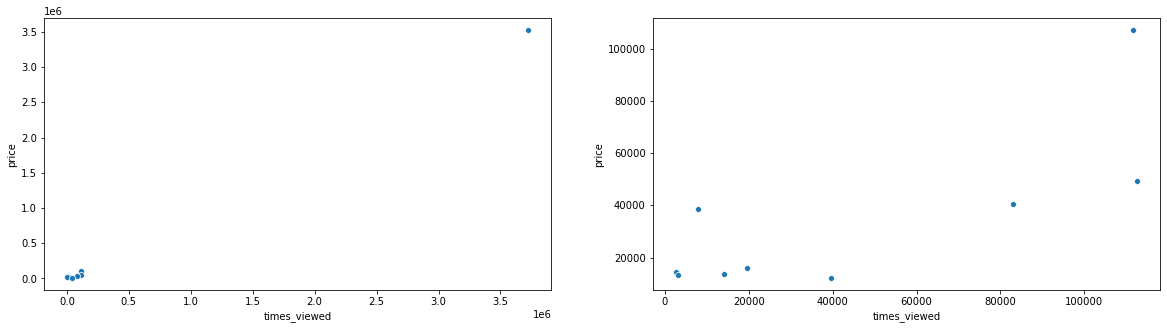

In [17]:
fig, ax = plt.subplots(1,2, figsize = (20,5));
sns.scatterplot(ax = ax[0], data = grouped_top_ten_df, x = 'times_viewed', y = 'price');
sns.scatterplot(ax = ax[1], data = grouped_top_nine, x = 'times_viewed', y = 'price');
